In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
import matplotlib.colors as colors
import matplotlib.cm as cmx
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC 
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

from Notebook_helpers import load_data
from Notebook_helpers.modeling_helpers import *

%matplotlib inline

## Read in the data

In [3]:
df, train, val, test = load_data.load_coral_data(complete=True, CV=False, convert_to_categorical=True)

## Logistic Regression

#### Data Prep

In [4]:
# isolate the predictors and labels for both the training and test set
train_X, train_y, pred_names = load_data.get_features_and_response(train, with_feature_eng = False)
val_X, val_y, _ = load_data.get_features_and_response(val, with_feature_eng = False)

##### Standardize the data

In [6]:
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(train_X.values)

# Apply transform to both the training set and the test set.
train_X = scaler.transform(train_X.values)
val_X = scaler.transform(val_X.values)

### Multiclass logistic regression model (one vs. rest)

##### Fit the model & make predictions

In [7]:
clf = LogisticRegression(solver='liblinear', multi_class='ovr')
clf.fit(train_X, train_y)
#clf = LogisticRegression(random_state=0, solver='saga', multi_class='multinomial').fit(train_X, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [8]:
# make predictions
val_pred = clf.predict(val_X)

##### Evaluate performance

Misclassified samples: 36
Classification Report:
              precision    recall  f1-score   support

           1       0.68      0.65      0.67        26
           2       0.77      0.82      0.79        28
           3       0.54      0.60      0.57        25
           5       0.53      0.43      0.47        21

    accuracy                           0.64       100
   macro avg       0.63      0.63      0.62       100
weighted avg       0.64      0.64      0.64       100



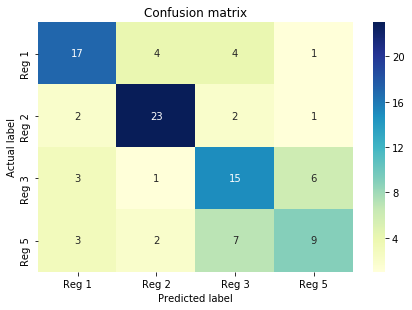

In [9]:
evaluate_performance(val_y, val_pred)

##### Examining variable importance
Since this is no longer a focus for the project, I'm not doing this for the other models. Just keeping this here in case we want to revisit it for the final project writeup.

In [10]:
# create a data frame with the coefficients for all the multiclass logit coefficients
coef_ovr = pd.DataFrame(clf.coef_, index=clf.classes_, columns=pred_names)

In [11]:
# sort predictors by the magnitude of their coefficients for regime 1
np.abs(coef_ovr.iloc[[0,]]).sort_values(by=1, axis=1, ascending=False)

,Complexity,Fishing_NonComm_Boat_Total,Fishing_Comm_Total,Fishing_NonComm_Shore_Spear,SST_CLIM_M,Fishing_NonComm_Shore_Net,Habitat_Modification,SST_STD,Fishing_NonComm_Shore_Line,CHL_ANOM_F,CHL_CLIM_M,New_Development,Effluent,WAV_ANOM_F,Depth,Sedimentation,PAR_CLIM_M,WAV_CLIM_M,PAR_STD,Invasive_Algae
1,1.125321,0.896707,0.56489,0.497815,0.493902,0.360658,0.353188,0.338944,0.302361,0.264709,0.146259,0.103214,0.083776,0.042413,0.034782,0.031995,0.028,0.011868,0.007664,0.005971


In [12]:
# for regime 2
np.abs(coef_ovr.iloc[[1,]]).sort_values(by=2, axis=1, ascending=False)

,SST_CLIM_M,WAV_CLIM_M,Fishing_NonComm_Shore_Net,Fishing_NonComm_Boat_Total,CHL_ANOM_F,WAV_ANOM_F,Fishing_Comm_Total,Fishing_NonComm_Shore_Spear,SST_STD,PAR_STD,Sedimentation,New_Development,Invasive_Algae,Complexity,Habitat_Modification,PAR_CLIM_M,Fishing_NonComm_Shore_Line,Effluent,CHL_CLIM_M,Depth
2,0.724466,0.429314,0.418581,0.364577,0.324644,0.323114,0.31862,0.303084,0.290733,0.274034,0.260498,0.227959,0.227581,0.22489,0.205873,0.13846,0.089077,0.067752,0.032621,0.032601


In [13]:
# for regime 3
np.abs(coef_ovr.iloc[[2,]]).sort_values(by=3, axis=1, ascending=False)

,SST_CLIM_M,CHL_CLIM_M,Invasive_Algae,PAR_CLIM_M,PAR_STD,Fishing_NonComm_Shore_Net,SST_STD,Fishing_NonComm_Shore_Line,Fishing_NonComm_Boat_Total,Sedimentation,CHL_ANOM_F,Fishing_Comm_Total,New_Development,Depth,Fishing_NonComm_Shore_Spear,Habitat_Modification,WAV_ANOM_F,WAV_CLIM_M,Complexity,Effluent
3,0.863473,0.674998,0.572055,0.502326,0.495681,0.480769,0.438853,0.413594,0.371087,0.360325,0.338164,0.26101,0.256709,0.224685,0.220567,0.189897,0.15136,0.089837,0.061165,0.058662


In [14]:
# for regime 5
np.abs(coef_ovr.iloc[[3,]]).sort_values(by=5, axis=1, ascending=False)

,WAV_CLIM_M,PAR_CLIM_M,Fishing_NonComm_Boat_Total,Invasive_Algae,PAR_STD,Complexity,Fishing_NonComm_Shore_Net,SST_CLIM_M,Fishing_Comm_Total,Fishing_NonComm_Shore_Line,New_Development,SST_STD,CHL_CLIM_M,Depth,CHL_ANOM_F,WAV_ANOM_F,Fishing_NonComm_Shore_Spear,Habitat_Modification,Sedimentation,Effluent
5,0.968901,0.860436,0.684552,0.659847,0.632091,0.489745,0.464468,0.42416,0.423275,0.401427,0.377536,0.36733,0.365008,0.329893,0.303874,0.229534,0.14736,0.132827,0.06583,0.058964


### Multiclass logistic regression model (multinomial)

##### Fit the model & make predictions

In [15]:
clf_multi = LogisticRegression(solver='newton-cg', multi_class='multinomial')
clf_multi.fit(train_X, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
# make predictions
val_pred_multi = clf_multi.predict(val_X)

##### Evaluate performance

Misclassified samples: 34
Classification Report:
              precision    recall  f1-score   support

           1       0.65      0.65      0.65        26
           2       0.79      0.79      0.79        28
           3       0.58      0.72      0.64        25
           5       0.60      0.43      0.50        21

    accuracy                           0.66       100
   macro avg       0.66      0.65      0.65       100
weighted avg       0.66      0.66      0.66       100



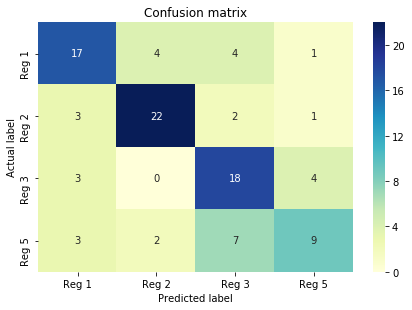

In [17]:
evaluate_performance(val_y, val_pred_multi)

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, zero_one_loss
C = np.logspace(-4, 4, 15)
hyperparameters = dict(C=C)
clf = GridSearchCV(LogisticRegression(solver='newton-cg',
                                      multi_class='multinomial', 
                                      penalty='l2',
                                      random_state=1), 
                   hyperparameters, cv=5, verbose=0, iid=False,
                   scoring=make_scorer(metrics.f1_score, average='micro', greater_is_better=True),
                   return_train_score=True)
best_model = clf.fit(train_X, train_y)

# Best Model is the model picked with the optimal C retrained on the
# entire training data.

print('Best C:', best_model.best_estimator_.get_params()['C'])

Best C: 0.07196856730011514


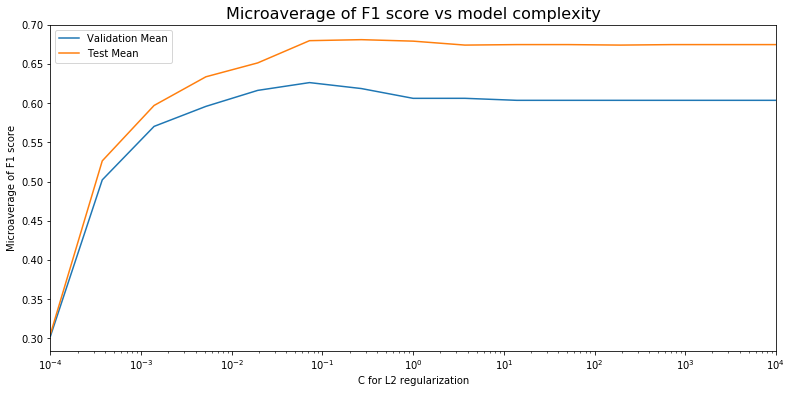

In [19]:
# from scikit-learn, "Demonstration of multi-metric evaluation on cross_val_score and GridSearchCV" 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
results = clf.cv_results_

plt.figure(figsize=(13, 6))
plt.title("Microaverage of F1 score vs model complexity",
          fontsize=16)

plt.xlabel("C for L2 regularization")
plt.ylabel("Microaverage of F1 score")

ax = plt.gca()
plt.xscale("log")
ax.set_xlim(C[0], C[-1])

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_C'].data, dtype=float)

sample_score_mean = results['mean_test_score']
# sample_score_std = results['std_test_score']

train_score_mean = results['mean_train_score']

# add error bars
plt.errorbar(x = X_axis, y = sample_score_mean, 
             label='Validation Mean', capsize=4, capthick=2)
plt.errorbar(x = X_axis, y = train_score_mean, 
             label='Train Mean', capsize=4, capthick=2)

plt.legend()

plt.grid(False)
plt.show()

## Confusion matrix for Cross Validated Regularization

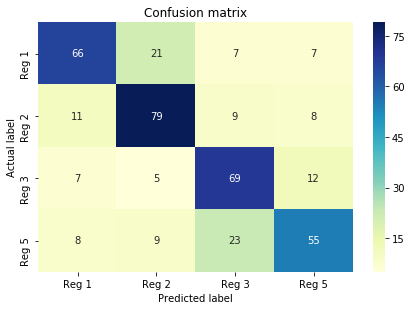

In [20]:
train_pred_multi = best_model.predict(train_X)
evaluate_performance(train_y, train_pred_multi, False)

## Error Analysis